In [1]:
import siibra
assert siibra.__version__ >= "1.0a17"
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting

/Users/tdickscheid/Documents/manuscripts/in-prep/2024.dickscheid.siibra/tex/figures/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[siibra:INFO] Version: 1.0a17
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


## short form

In [88]:
# 1: get a region map
area, hemisphere = '4p', 'right'
parc = siibra.parcellations.get('julich 3.0.3')
region = parc.get_region(f"{area} {hemisphere}")
pmap = parc.get_map('mni152', 'statistical').fetch(region)

[siibra:WARNING] Multiple maps are available in this specification of space, parcellation, and map type.
Choosing the first map from ['mni152 jba30 157regions statistical', 'mni152 jba30 175regions statistical'].


In [122]:
# 2: find a corresponding brain section
v = siibra.volumes.from_nifti(pmap, space='mni152', name=region.name)
features = siibra.features.get(v.get_boundingbox(), "CellbodyStainedSection")
section = features[23]

TypeError: from_nifti() missing 1 required positional argument: 'name'

In [96]:
# 3: project layer surfaces to the section
imgplane = siibra.experimental.Plane3D.from_image(section)
lmap = siibra.get_map('cortical layers', space='bigbrain')
l4 = lmap.parcellation.get_region('4 ' + hemisphere)
contour = imgplane.intersect_mesh(lmap.fetch(l4, format='mesh'))

In [97]:
# 4: Find a relevant cortical profile
points = siibra.locations.from_points(sum(map(list, contour), []))
probs = v.evaluate_points(points)
sampler = siibra.experimental.CorticalProfileSampler()
prof = sampler.query(points[probs.argmax()])

Best match is vertex #421541 in cortical layer 4 right.


In [98]:
# 5: extract the cortical patch
canvas = imgplane.get_enclosing_patch(prof)
canvas.flip()
patch = canvas.extract_volume(section, resolution_mm=-1)

[siibra:WARNING] Created BoundedBox's have zero volume.
[siibra:WARNING] Created BoundedBox's have zero volume.


(np.float64(-0.5), np.float64(1679.5), np.float64(2869.5), np.float64(-0.5))

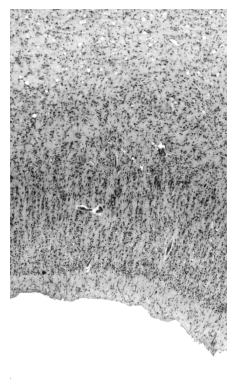

In [99]:
plt.figure()
patchimg = patch.fetch()
patchdata = patchimg.get_fdata().squeeze()
plt.imshow(patchdata, cmap='gray', vmin=0, vmax=2**16)
plt.axis('off')

## plot the results

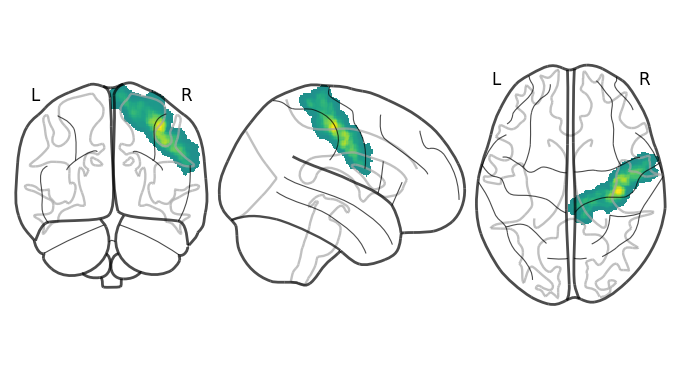

In [105]:
plotting.plot_glass_brain(pmap, cmap='viridis', symmetric_cbar=True)

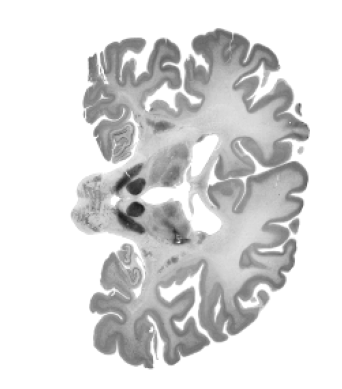

In [106]:
im_low_res = section.fetch(resolution_mm=0.8)
plt.figure()
plt.imshow(im_low_res.get_fdata().squeeze(), cmap='gray', vmin=0, vmax=2**16)
plt.axis('off')

layercolors = {
    l:lmap.get_colormap().colors[lmap.get_index(l).label]
    for l in lmap.regions
}
all_contours = {
    l: imgplane.intersect_mesh(lmap.fetch(l, format='mesh'))
    for l in lmap.regions
}

phys2pix = np.linalg.inv(im_low_res.affine)

[siibra:INFO] Since provided voi lies outside the template (BigBrain microscopic template (histology)) it is clipped as: Bounding box from (-18.65,1.09,5.65) mm to (56.78,1.11,62.09)mm in BigBrain microscopic template (histology) space


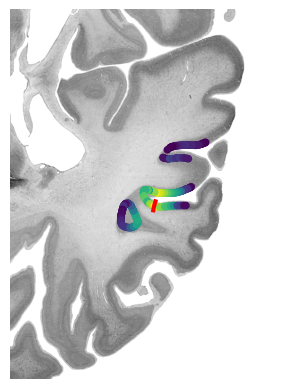

In [107]:
crop_voi = section.get_boundingbox().intersection(v.get_boundingbox())
crop = section.fetch(voi=crop_voi, resolution_mm=0.04)
phys2pix = np.linalg.inv(crop.affine)
plt.figure()
plt.imshow(crop.get_fdata().squeeze(), cmap='gray', vmin=0, vmax=2**16)
plt.axis(False)

show_profile = True
if show_profile:
    selection = probs > 0.05
    P = siibra.locations.from_points([pt for pt, ok in zip(points, selection) if ok])
    X, Y, Z = P.transform(phys2pix, space=None).homogeneous.T[:3]
    plt.scatter(Z, X, s=20, cmap='viridis', c=probs[selection]/probs.max())
    X, Y, Z = prof.transform(phys2pix, space=None).homogeneous.T[:3]
    plt.plot(Z, X, 'r-', lw=3)

else:
    for layername, lst in all_contours.items():
        for cts in lst:
            pixels = cts.transform(phys2pix, space=None).homogeneous
            plt.plot(pixels[:, 2], pixels[:, 0], '-', color=layercolors[layername]) 


## Select a probability map of a cortical brain region from the Julich-Brain atlas

We start this tutorial by selecting a cortical brain region from the Julich-Brain cytoarchitectonic atlas. 

In [108]:
# we will search for the region by keywords
regionspec = '4p'
hemisphere = 'right'

In [109]:
# Get the parcellation, its map in MNI space
julichbrain = siibra.parcellations.get('julich 3.0.3')
region = julichbrain.get_region(f'{regionspec} {hemisphere}')

In [110]:
# get access to the corresponding probabilistic maps in MNI space, 
# and fetch the one for the selected region.
julich_pmaps = julichbrain.get_map(space='mni152', maptype='statistical')
pmap = julich_pmaps.fetch(region=region)

[siibra:WARNING] Multiple maps are available in this specification of space, parcellation, and map type.
Choosing the first map from ['mni152 jba30 157regions statistical', 'mni152 jba30 175regions statistical'].


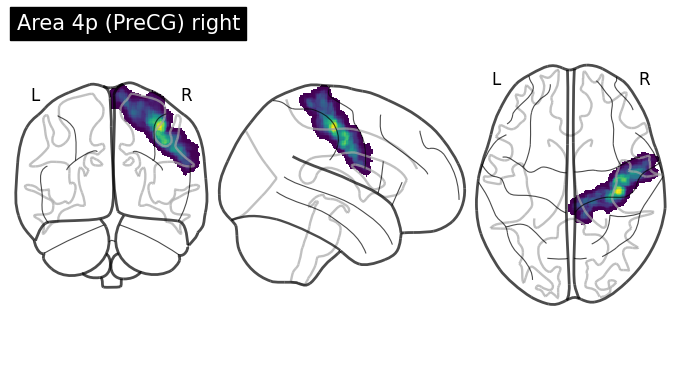

In [111]:
# The result is a NIfTI image object.
# We can plot it with common neuroscience libraries; 
# here we juse nilearn's wonderful 'plotting' module.
plotting.plot_glass_brain(pmap, cmap='viridis', title=region.name)

## Find a 1-micron section intersecting the brain region

We can use region maps to query spatial features.
Here we search for 1 micron sections of the BigBrain which intersect with the region map.
Note that siibra automatically resovles the mismatch between the template spaces:
It will warp the bounding boxes of BigBrain sections to MNI space for the query.

In [112]:
# find 1 micron section in bigbrain space which overlaps with the region
pmap_volume = siibra.volumes.from_nifti(pmap, space='mni152', name=region.name)
sections = siibra.features.get(pmap_volume.get_boundingbox(), siibra.features.cellular.CellbodyStainedSection)
section = sections[23]

Matching CellbodyStainedSection to Bounding box from (-3.00,-49.00,11.00) mm t


## Intersect surface meshes with the image plane

We are interested in cortical structure. Here it is very hepful to project the cortical layer surfaces to the image section. This is a 3D to 2D projection, leading to sets of (possibly split) contours of the layer surfaces.

In [113]:
# access cortical layer maps in BigBrain space
layers = siibra.parcellations.get('cortical layers')
layermap = layers.get_map(space='bigbrain')

# Derive a 3D plan from the 1 micron section.
# Note that the 1 micron section is a 3D image volume,
# however its y-dimension is flat. 
# Siibra will create a plane from the smallest image dimension.
# The plane is defined in the physical brain reference space.
imgplane = siibra.experimental.Plane3D.from_image(section)
print(f"Extracted a plane in {imgplane.space} space, with normal {imgplane.normal}.")

# Intersect all meshes in the parcellation map with this plane
# to obtain layer contours. 
# The contours are represented as ordered sets of points.
layer_contours = {
    l: imgplane.intersect_mesh(layermap.fetch(region=l, format='mesh'))
    for l in layermap.regions
}

for layername, contours in layer_contours.items():
    print(
        f" - {layername+':':30} {len(contours)} intersected contours."
    )

Extracted a plane in BigBrain microscopic template (histology) space, with normal [ 0. -1.  0.].
 - cortical layer 1 left:         5 intersected contours.
 - cortical layer 2 left:         6 intersected contours.
 - cortical layer 3 left:         3 intersected contours.
 - cortical layer 4 left:         4 intersected contours.
 - cortical layer 5 left:         5 intersected contours.
 - cortical layer 6 left:         5 intersected contours.
 - non-cortical structures left:  3 intersected contours.
 - cortical layer 1 right:        3 intersected contours.
 - cortical layer 2 right:        6 intersected contours.
 - cortical layer 3 right:        6 intersected contours.
 - cortical layer 4 right:        6 intersected contours.
 - cortical layer 5 right:        7 intersected contours.
 - cortical layer 6 right:        5 intersected contours.
 - non-cortical structures right: 4 intersected contours.


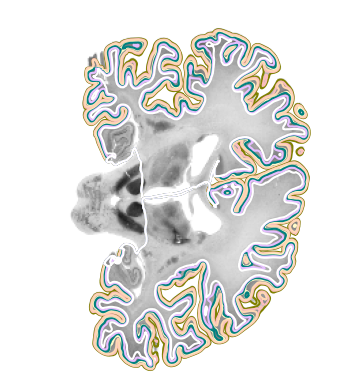

In [114]:
# plot the layer contours with a lower resolution version of the image section.
# We do this with matplotlib, using the actual pixel space of the image,
# so the image is not properly oriented here.

# fetch a 0.8mm version
im_low_res = section.fetch(resolution_mm=0.8)

plt.figure()
plt.imshow(im_low_res.get_fdata().squeeze(), cmap='gray', vmin=0, vmax=2**16)
plt.axis('off')

# siibra's map objects typically provide colormaps, let's use them!
layercolors = {
    l:layermap.get_colormap().colors[layermap.get_index(l).label]
    for l in layermap.regions
}

# plot the contours
for layername, contour_list in layer_contours.items():
    for contours in contour_list:
        phys2pix = np.linalg.inv(im_low_res.affine)
        pixels = contours.transform(phys2pix, space=None).homogeneous
        plt.plot(pixels[:, 2], pixels[:, 0], '-', color=layercolors[layername]) 

## Find a closeby cortical profile in the brain region

We want to find a cortical profile which is likely in the selected brain region, and also as close as possible to the image section.

We do so by looking up the values of layer IV contour points in the region map, and selecting the point with highest probability.

Then we find the "column" of corresponding surface vertices in the cortical layer maps closest to the contour point.

In [115]:
# find the most probable contour point in the layer 4 surface
l4layer = layers.get_region(f"4 {hemisphere}")

# collect all layer IV contour points into one set
l4points = siibra.PointSet(
    [p for contour in layer_contours[l4layer.name] for p in contour], 
    space='bigbrain'
)

# use the probabilistic map volume to lookup their values 
probs = pmap_volume.evaluate_points(l4points)

# get the highest ranked point
l4point = l4points[probs.argmax()]

# siibra has an experimental class for querying cortical profiles
profile = siibra.experimental.CorticalProfileSampler().query(l4point)

Best match is vertex #421541 in cortical layer 4 right.


[siibra:INFO] Since provided voi lies outside the template (BigBrain microscopic template (histology)) it is clipped as: Bounding box from (-18.65,1.09,5.65) mm to (56.78,1.11,62.09)mm in BigBrain microscopic template (histology) space


(np.float64(-0.5),
 np.float64(439.5),
 np.float64(618.7079373874224),
 np.float64(-0.5))

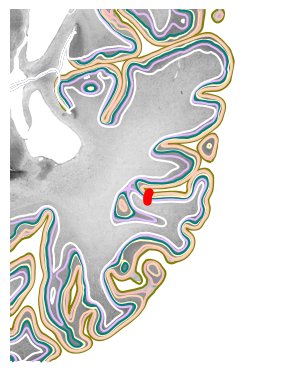

In [116]:
# plot the image crop around the brain region with layers and the profile
crop_voi = section.get_boundingbox().intersection(pmap_volume.get_boundingbox())
crop = section.fetch(voi=crop_voi, resolution_mm=0.2)
phys2pix = np.linalg.inv(crop.affine)

# plot the image
plt.figure()
plt.imshow(crop.get_fdata().squeeze(), cmap='gray', vmin=0, vmax=2**16)

# plot the contour segments
for layername, contours in layer_contours.items():
    for contour in contours:
        for segment in contour.crop(crop_voi):
            pixels = segment.transform(phys2pix, space=None).homogeneous
            plt.plot(pixels[:, 2], pixels[:, 0], '-', ms=4, color=layercolors[layername])

# plot the profile points
for p in profile:
    x, y, z = p.transform(phys2pix, space=None)
    plt.plot(z, x, 'r.', ms=10)
    
plt.axis('off')

[siibra:INFO] Since provided voi lies outside the template (BigBrain microscopic template (histology)) it is clipped as: Bounding box from (-18.65,1.09,5.65) mm to (56.78,1.11,62.09)mm in BigBrain microscopic template (histology) space


(np.float64(-0.5),
 np.float64(439.5),
 np.float64(618.7079373874224),
 np.float64(-0.5))

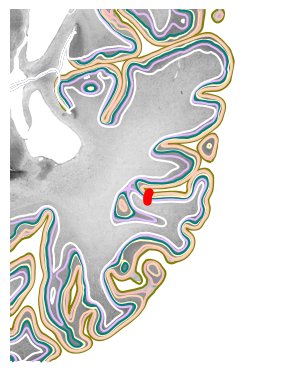

In [118]:
# plot the image crop around the brain region with layers and the profile
crop_voi = section.get_boundingbox().intersection(pmap_volume.get_boundingbox())
crop = section.fetch(voi=crop_voi, resolution_mm=0.2)
phys2pix = np.linalg.inv(crop.affine)

# plot the image
plt.figure()
plt.imshow(crop.get_fdata().squeeze(), cmap='gray', vmin=0, vmax=2**16)

# plot the contour segments
for layername, contours in layer_contours.items():
    for contour in contours:
        for segment in contour.crop(crop_voi):
            pixels = segment.transform(phys2pix, space=None).homogeneous
            plt.plot(pixels[:, 2], pixels[:, 0], '-', ms=4, color=layercolors[layername])

# plot the profile points
for p in profile:
    x, y, z = p.transform(phys2pix, space=None)
    plt.plot(z, x, 'r.', ms=10)
    
plt.axis('off')

## Define the cortical image patch including the profile

Now extract a cortical patch from the section which is centered around the layer 4 point and approximately rotated orthogonal to the brain surface.

siibra's Plane3D class can extract a rotated patch definition from a set of points, which are projected onto the plane.
The rotation is derived from the principal axes of the projected points.
The patch can then extract image data in the new orientation from the original image volume.

Since this function is not aware of the special ordering of the profile points however, the patch might be extracted upside down. 
We can detect this using a bit of a hack, by checking to which of the corner points the inner surface point is closest, and flip if required.

In [119]:
patch_canvas = imgplane.get_enclosing_patch(profile)
i = np.argmin(
    np.linalg.norm((patch_canvas.corners.coordinates - profile[0].coordinate), axis=1)
)
if i in [0, 3]:
    patch_canvas.flip()
    
# now fetch the image data
patch = patch_canvas.extract_volume(section, resolution_mm=0.01)

[siibra:WARNING] Created BoundedBox's have zero volume.
[siibra:WARNING] Requested resolution 0.01 is not available. Falling back to the highest possible resolution of 0.001, 0.02, 0.001 mm.
[siibra:WARNING] Created BoundedBox's have zero volume.


/Users/tdickscheid/Documents/manuscripts/in-prep/2024.dickscheid.siibra/tex/figures/venv/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:315: UserWarning: Too many cuts requested for the data: n_cuts=7, data size=1.
  warnings.warn(
[siibra:WARNING] Resolution was reduced to [0.33866667 0.32       0.33866667] to provide a feasible volume size of 0.2 GiB. Set `max_bytes` to fetch in the resolution requested.


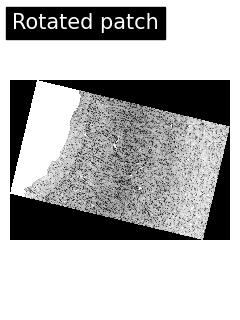

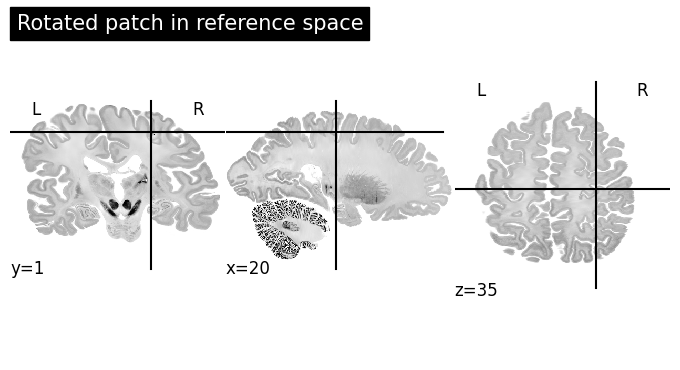

In [120]:
# plot the patch individually, and in 3D context.
# Here we first use nilearn plotting functions with the resulting NIfTI files,
# so the extracted patch is still shown in its anatomical orientation.
view = plotting.plot_img(patch.fetch(), cmap='gray', display_mode='y', annotate=False, title=f"Rotated patch")
template = siibra.get_template("bigbrain")
bigbrain_lowres = template.fetch(resolution_mm=0.2)
view = plotting.plot_img(patch.fetch(), bg_img=bigbrain_lowres, cmap='gray', title="Rotated patch in reference space")

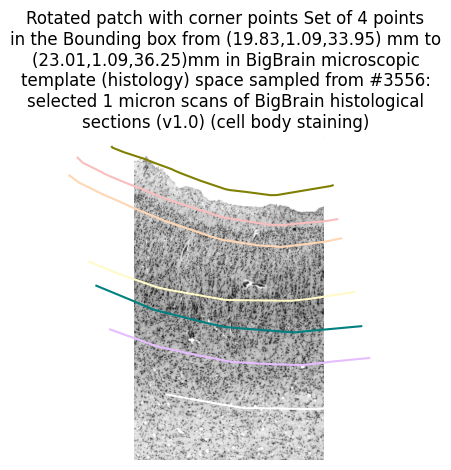

In [121]:
# to verify that the underlying pixels have been resampled
# into local cortical orientation, we display the underlying image
# using matplotlib.

plt.figure()

# access the underlying image data
patchimg = patch.fetch()
phys2vox = np.linalg.inv(patchimg.affine)
patchdata = patchimg.get_fdata().squeeze()

# plot the pure image array
plt.imshow(patchdata, cmap='gray', vmin=0, vmax=2**16)
plt.axis('off')


# overlay fragments of intersected layer surface contours.
for layername, contours in layer_contours.items():
    for contour in contours:
        for s in contour.crop(patch.get_boundingbox()):
            pixels = s.transform(phys2vox, space=None).homogeneous
            plt.plot(pixels[:, 2], pixels[:, 0], '-', ms=4, color=layercolors[layername])

# let's show the title of the extracted patch for fun...
import textwrap
plt.title("\n".join(textwrap.wrap(patch.name, 50)))

plt.tight_layout()